# Sentiment Analysis, Part 2: NLP With Spark On Google Cloud
---------------

__[1. Introduction](#bullet1)__

__[2. Creating A GCP Hadoop Cluster ](#bullet2)__

__[3. Getting Data From An Atlas Cluter](#bullet3)__

__[4. Basic Models With Spark PiplineModels](#bullet4)__

__[5. Stemming With Custom Transformers](#bullet5)__

__[6. N-Grams And Parameter Tunning With Cross Validation](#bullet6)__

__[7. Conclusions](#bullet7)__


## Introduction  <a class="anchor" id="bullet1"></a>
--------------

In the <a href="http://michael-harmon.com/blog/SentimentAnalysisP1.html">first part</a> of this two part blog post I went over the basics of ETL with PySpark and MongoDB.  In this second part I will go over the actual modeling aspect of Sentiment Anlysis using <a href="https://spark.apache.org/docs/latest/ml-guide.html">SparkML</a> (aka MLlib, it seems the name is changing).  Specifically, well be using <a href="https://spark.apache.org/docs/latest/ml-pipeline.html">MLPipelines</a> and <a href="https://en.wikipedia.org/wiki/Logistic_regression">Logistic Regression</a> to build a basic linear classifier for sentiment.  Then we'll introduce a custom <a href="https://spark.apache.org/docs/1.6.2/ml-guide.html#transformers">Transformer</a> class which uses the <a href="https://www.nltk.org/">NLTK</a> to performing stemming.  Lastly, we'll inroduce N-grams and go over <a href="https://spark.apache.org/docs/latest/ml-tuning.html">hyper-parameter tunning</a> with cross-validation. The point of this post *is not too build the best classifier on a huge dataset, but rather to show how to piece together advanced concepts into a ML Pipeline using PySpark... and at the same time get reasonable results.*

That said we will continue to use the 1.6 million <a href="https://www.kaggle.com/kazanova/sentiment140">tweets</a> from Kaggle which I loaded onto my <a href="https://www.mongodb.com/cloud/atlas">Atlas MongoDB</a> cluster with the Spark job that was discussed in the last post.  While 1.6 million tweets doesn't necessitate a distributed environment, using PySpark on this datset was a little too much my whimpy 2013 Macbook Air and I needed to use a more powerful machine.  Luckily <a href="https://cloud.google.com/">Google Cloud Platform</a> (GCP) gives everyone free credits to start using their platform and I was able to use Spark on a <a href="https://hadoop.apache.org/">Hadoop</a> cluster using <a href="https://cloud.google.com/dataproc/">dataproc</a> and <a href="https://cloud.google.com/datalab/">datalab</a>. 


Let's get started!


## Creating A GCP Hadoop Cluster  <a class="anchor" id="bullet2"></a>
---------
I have been using Hadoop and Spark for quite some time now, but have never spun up my own cluster and gained a new found respect for Hadoop admins.  Google does make the process easier, but I had to ask a friend for help to get things to work as I wanted.  Between getting the correct version of Python as well as the correct version of NLTK on both the driver and worker nodes, the correct MongoDB connector for PySpark 2.3.2 and the time it takes to spin up and shut down a cluster I was very much done configuting Hadoop clusters on my own.  I want to say that made me a better person or atleast data scientist, but I'm not so sure. :)

To start up the Hadoop cluster I used the command below with two nodes is shown below (o the GCP free trial I could only pass use two worker nodes):

![](images/CreateCluster.png)

You can see the string for the MongoDB connector as well as the version of Python in the commands.  The bash scripts that I reference in my Google storage bucket for this project can be seen in my repo <a href="https://github.com/mdh266/SentimentAnalysis/tree/master/GCP">here</a>.  After the cluster is created we  can ssh onto the master node by going to the console and clicking on "*Compute Enginee* tab.  You will see a page like the one below:

![](images/MasterNode.png)

We can ssh on the master node using the ssh tap to the right of the instance name **mikescluster-m**.  The "-m" signifies it is the master node while the other instances have "-w" signifiying they are worker ndoes. After connecting to the mater node you can see all the <a href="https://data-flair.training/blogs/top-hadoop-hdfs-commands-tutorial/">Hadoop commands</a> available:


![](images/HDFS.png)

However, we won't work on our Hadoop cluster through command line, but rather connect to the cluster through Jupyter notebooks using Google <a href="https://cloud.google.com/datalab/">datalab</a>. To do this involves creating an ssh-tunnel and proxy for Chrome, both of which I had no idea how to do, but luckily had friend walk me through it.  The bash scripts I used to do these last two steps are located in my repo <a href="https://github.com/mdh266/SentimentAnalysis/tree/master/GCP">here</a>. After those steps were completed we can just go to the address to see the Jupyter notebooks,

    http://mikescluster-m:8080
 
Note that that notebooks are running on the master node using port 8080 and that <a href="https://hadoop.apache.org/docs/current/hadoop-yarn/hadoop-yarn-site/YARN.html">YARN</a> can be see from the same address but with port 8088 which I'll come back to a little later.  Now that we have our Hadoop cluster up and running on Google Cloud we need to access our data.

## Getting The Dataset From An Atlas Cluster <a class="anchor" id="bullet3"></a>
---------

As I mentioned in the introduction I loaded the cleaned Twitter dataset into my Atlast MongoDB cluster and the ETL job was discussed in the previous <a href="http://michael-harmon.com/blog/SentimentAnalysisP1.html">post</a>.  In this post I won't go over the ETL process again, but will show how to connect PySpark to the Atlas cluster.  One thing to note is that to keep my collection with the limits of the free tier using Atlas I had to store the data as strings and not tokenized so we'll do have to tokenize our strings again here.

The first step to connecting to the database is to create a connection url string that contains the cluster address, user info, as well as database and collection name in the dictionary below:

In [1]:
mongo_conn = {"address"    : "harmoncluster-xsarp.mongodb.net/", 
              "db_name"    : "db_twitter",
              "collection" : "tweets",
              "user"       : "",
              "password"   : ""}

url   = "mongodb+srv://{user}:{password}@{address}{db_name}.{collection}".format(**mongo_conn)

Then we read documents the collection using the <code>spark.read</code> command passing in that we are using MongoDB as the format and the url as our option:

In [2]:
df = spark.read\
          .format("com.mongodb.spark.sql.DefaultSource")\
          .option("uri",url)\
          .load()

At this point, while the data hasn't quite been pulled from the source yet, but we would still see an error if there was a mistake in our connection string.  While we have pulled the documents from our collection on the Atlas cluster to our Hadoop cluster we have still have some metadata on the collection and can infer schema using the command below:

In [3]:
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- sentiment: integer (nullable = true)
 |-- tweet_clean: string (nullable = true)



You can see that each document has an <code>id</code>, <code>sentiment</code> and the cleaneed tweet, <code>tweet_clean</code>.  Let's just pull the cleaned tweet and sentiment fields and rename `sentiment` to `label`:

In [5]:
df2 = df.select("tweet_clean","sentiment")\
        .withColumnRenamed("sentiment", "label")

Then we split into training and testing sets (using 80% of the data for training and 20% for testing) with a seed (1234) below,

In [6]:
train, test = df2.randomSplit([0.80, 0.20], 1234)

Now we can look at the number of training tweets with positive and negative sentiment below. Note, since our well be using this dataframe multiple times in the machine learning pipelines we cache it for better performance.

In [7]:
train.cache()

DataFrame[tweet_clean: string, label: int]

In [8]:
train.groupby("label")\
     .count()\
     .show()

+-----+------+
|label| count|
+-----+------+
|    1|637317|
|    0|639237|
+-----+------+



We can see that the classes are well balanced with over half a million positive and negative teets.  We do the same for the test set:

In [9]:
test.cache()

DataFrame[tweet_clean: string, label: int]

In [10]:
test.groupby("label")\
    .count()\
    .show()

+-----+------+
|label| count|
+-----+------+
|    1|159635|
|    0|159840|
+-----+------+



Again, the classes in the test sets are well balanced.  This is great because we don't have to worry about dealing with imbalanced classes and *accuracy and ROC's area under the curve (AUC) are good metrics to see how well our models are performing.*

Normally, I would do some exploratory data analysis on the dataset, but I given that I'm paying for time on a cluster I would rather stick to showing how to create Spark ML Pipelines in this post.

## Basic Pipeline Classifiers <a class="anchor" id="bullet4"></a>
------------
In this section well go over using a basic logistic regression model using Spark <a href="https://spark.apache.org/docs/latest/ml-pipeline.html">MLPipelines</a> which are similar to <a href="https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html">Scikit-learn Pipelines</a>. We import the basic modules below:

In [11]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

Next we instantiate our classification evalutor class and pass the label of the output column from pipeline model:

In [201]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# get the name of the metric used
evaluator.getMetricName()

'areaUnderROC'

We'll be using the <a href="https://en.wikipedia.org/wiki/Bag-of-words_model">**bag of words model**</a> to build features for our model from tweets.  *In the bag-of-words model, a document (in this case tweet) is represented as "bag" or list of its words, disregarding grammar and ordering, but keeping the multiplicity of the words.*  A two document example is:

- **D1:**  Hi, I am Mike and I like Boston.

- **D2:**  Boston is a city and people in Boston like the Red Sox.

From these two documents, a list, or 'bag-of-words' is constructed

    bag = ['Hi', 'I', 'am', 'Mike', 'and', 'like', 'Boston', 'is', 
           'a', 'city, 'and', 'people', 'in', 'the', 'red', 'sox]


Notice how in our bag-of-words we have dropped repetitions of the words 'I', 'is' and 'Mike', we will show how multiplicity of words enters into our model next. 

The bag-of-words model is mainly used as a tool of feature generation. After transforming the text into a "bag of words", we can calculate various measures to characterize the document.  In order to do so we have to generate a vector for each document that represents the number of times each entry in the bag of words appears in the text. The order of entries in the vector corresponds to the order of the entries in the bag-of-words list.  For example, document D1 would have a vector,

    [1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0 ,0, 0, 0, 0, 0]
    
while the second document, D2, would have the vector,

    [0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]

Each entry of the lists refers to frequency or count of the corresponding entry in the bag-of-words list.  When we have a stacked collection of (row) vectors, or matrix, where each row corresponds to a document (vector), and each column corresponds to a word in the bag-of-words list, then this will be known as our **term-frequency ($\text{tf}$) [document matrix](https://en.wikipedia.org/wiki/Document-term_matrix)**. The general formula for an entry in the $\text{tf}$ matrix is,

$$\text{tf}(d,t) \,  = \, f_{t,d}$$
    
where $f_{t,d}$ is the number of times the term $t$ occurs in document $d \in \mathcal{D}$, where $\mathcal{D}$ is our text corpus.  We can create a term-frequency matrix using Spark's <a href="https://spark.apache.org/docs/latest/ml-features.html#tf-idf">HashingTF</a> class. To see the difference between HashingTF and <a href="https://spark.apache.org/docs/latest/ml-features.html#countvectorizer">CounterVectorizer<a/> see this <a href="https://stackoverflow.com/questions/35205865/what-is-the-difference-between-hashingtf-and-countvectorizer-in-spark">stackoverflow post</a>.

Most often term-frequency alone is not a good measure of the importance of a word/term to a document's topic.  Very common words like "the", "a", "to" are almost always the terms with the highest frequency in the text. Thus, having a high raw count of the number of times a term appears in a document does not necessarily mean that the corresponding word is more important. Furtermore, longer documents could have high frequency of terms that do not correlate with the document topic, but instead occur with high numbers solely due to the length of the document.

To circumvent the limination of term-frequency, we often normalize it by the **inverse document frequency (idf)**.  This results in the **term frequency-inverse document frequency (tf-idf)** matrix.  The *inverse document frequency is a measure of how much information the word provides, that is, whether the term is common or rare across all documents in the corpus*.  We can give a formal defintion of the inverse-document-frequency by letting $\mathcal{D}$ be the corpus or the set of all documents and $N$ is the number of documents in the corpus and $N_{t,D}$ be the number of documents that contain the term $t$ then, 

$$idf(t,\mathcal{D}) \, = \,  \log\left(\frac{N_{\mathcal{D}}}{1 + N_{t,\mathcal{D}}}\right) \, = \, -  \log\left(\frac{1 + N_{t,\mathcal{D}}}{N_{\mathcal{D}}}\right) $$

The reason for the presence of the $1$ is for smoothing.  Without it, if the term/word did not appear in any training documents, then its inverse-document-frequency would be $idf(t,\mathcal{D}) = \infty$.  However, with the presense of the $1$ it will now have $idf(t,\mathcal{D}) = 0$.


Now we can formally defined the term frequnecy-inverse document frequency as a normalized version of term-frequency,


$$\text{tf-idf}(t,d) \, = \, tf(t,d) \cdot idf(t,\mathcal{D}) $$

Like the term-frequency, the term frequency-inverse document frequency is a sparse matrix, where again, each row is a document in our training corpus ($\mathcal{D}$) and each column corresponds to a term/word in the bag-of-words list.  The $\text{tf-idf}$ matrix can be constructed using the SparkML <a href="https://spark.apache.org/docs/latest/ml-features.html#tf-idf">IDF</a> class.


The basic pipeline we will use includes:

    - tokenization
    - creating term frequency
    - creating term frequency inverse document frequency 
    - fitting a logistic regression model to the BOW created from the previou steps
    
This is all done in the short few lines below:

In [67]:
# create tokens from strings
tk = Tokenizer(inputCol= "tweet_clean", outputCol = "tokens")

# create term frequencies from tokens
tf1 = HashingTF(inputCol="tokens", outputCol="rawFeatures", numFeatures=1e5)

# create tf-idfs from the term frequneies
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=2.0)

# create basic logistic regression model
lr = LogisticRegression(maxIter=20)

# create basic pipeline
basic_pipeline = Pipeline(stages=[tk, tf1, idf, lr])

I'll note that the `numFeatures=1e5` means we set our "vocabulary" to contain 100,000 words (see above listed stackeroverflow comment for explanation of what this means). The `minDocFreq=2.0` requires that a word or token must appear a minimum of 2 documents to be counted towards a feature.  This parameter can act as form a of regularization.  Setting this value to larger integers increases the regularization by reducing the number of words we consider. This helps to combat overfitting by eliminating words which occur very rarely so they don't influence our model.

Now we can train perform tokenization, feature extraction (tf-idf) and train the model all with the following command:

In [68]:
model1         = basic_pipeline.fit(train)

Once we have trained the pipeline model we can predict it's perfromance on the test set using the <code>transform</code> method and using the <code>evaluate</code> method of the evaluator object.

In [69]:
# predict on test set
predictions1   = model1.transform(test)

# get the performance on the test set
score1         = evaluator.evaluate(predictions1)

print("AUC SCORE: {}".format(score1))

AUC SCORE: 0.8851466578396061


We can also get the accuracy on the test set. I couldn't really find any good documentation about how to do this without using the old MLlib (rdd based) library.  What made it even more confusing is that I had to use <a href="https://spark.apache.org/docs/2.3.2/mllib-evaluation-metrics.html">MulticlassMetrics</a> class to evualate the binary outcome, because the `BinaryClassificationMetrics` only had AUC and for ROC curve and AUC for Precision-Recall curve.  The code snippet to get the accuracy is below:

In [216]:
predictedAndLabels = predictions1.select(["prediction","label"])\
                                 .rdd.map(lambda r : (float(r[0]), float(r[1])))

from pyspark.mllib.evaluation import MulticlassMetrics

metrics = MulticlassMetrics(predictedAndLabels)

print("Test Set Accuracy: {}".format(metrics.accuracy))

Test Set Accuracy: 0.8138070271539244


88.5% of the area under the ROC curve and 81% accuracy pretty very good for Twitter sentiment analyis, but let's see if we can make easy any improvements with more advanced preprocessing.

### Removing Stop Words

One trick people use as a prepocessing step in NLP to remove stop words, i.e. common words that do not add any additional information into the model.  Examples of stop words are: 'a', 'the', 'and', etc.  We will remove stops from our tokens by using the <a href="https://spark.apache.org/docs/2.3.2/ml-features.html#stopwordsremover">StopWordsRemover</a> class.  We import it below,

In [70]:
from pyspark.ml.feature import StopWordsRemover

We can instantiate a new StopWordsRemover object setting input column to be result of the tokenization procedure.  Notice that the input column name for the HashingTF object is the same output column name of the StopWordRemover and create our new pipeline.

In [71]:
sw  = StopWordsRemover(inputCol="tokens", outputCol="filtered")
tf2 = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=1e5)

stopwords_pipleline = Pipeline(stages=[tk, sw, tf2, idf, lr])

We can now train our new model and evaluate its performance on the test set:

In [72]:
model2         = stopwords_pipleline.fit(train)
predictions2   = model2.transform(test)
score2         = evaluator.evaluate(predictions2)

print("AUC SCORE: {}".format(score2))

AUC SCORE: 0.8725249381777652


Notice how easy it was to add a new stage in our MLPipeline and train our model!

We can see that the AUC for our ROC went down by a little over 1.5%.  At first I was pretty puzzled by this and spent a lot of time trying to fix it only to learn that blindly removing stop words isn't always the best practice for sentiment analysis, especially when it comes to <a href="http://www.lrec-conf.org/proceedings/lrec2014/pdf/292_Paper.pdf">tweets</a>.  Since removing stopped words gave our model worse performanace, we wont use it going forward.  However, it's worth while to see examples of words that were removed.  We do this below:

In [162]:
predictions2.select(["tweet_clean","tokens","filtered"]).show(5)

+--------------------+--------------------+--------------------+
|         tweet_clean|              tokens|            filtered|
+--------------------+--------------------+--------------------+
|a and yr old both...|[a, and, yr, old,...|[yr, old, girls, ...|
|a baby bird fell ...|[a, baby, bird, f...|[baby, bird, fell...|
|a baby llama was ...|[a, baby, llama, ...|[baby, llama, bor...|
|a beautiful day t...|[a, beautiful, da...|[beautiful, day, ...|
|a bicyclist was j...|[a, bicyclist, wa...|[bicyclist, hit, ...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



We can see that words like, 'a', 'and', 'was', and 'both' were removed.  Removing stop words is more helpful for the case of <a href="http://michael-harmon.com/blog/NLP.html">document classification</a>, where often the class a document belongs to is determined by a few key words and removing stop words can help to understand what those key words are. 


## Stemming With Customer Tranformers <a class="anchor" id="bullet5"></a>
------------

Another trick for preprocessing in NLP is stemming.  We will use the Natural Language Tool Kit (<a href="https://www.nltk.org/">NLTK</a> ) with the Porter Stemmer for stemming.  Stemming is the process of reducing words down to their root,  for example from Wikipedia :

...the Porter algorithm reduces, argue, argued, argues, arguing, and argus all get reduced to the stem argu 

Stemming is used as an approximate method for grouping words with a similar basic meaning together.  For NLP and the bag of words model this reduces the dimension of our feature space since variations in words that would normally be counted seperately are reduced to one word that is counted collectively. 


For some reason gcloud kept installing the wrong version of NLTK and inorder to get the correct version on the driver and workers I had to install within the notebook

In [30]:
%sh
pip install -U nltk==3.4

  Running setup.py bdist_wheel for nltk: started
  Running setup.py bdist_wheel for nltk: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/4b/c8/24/b2343664bcceb7147efeb21c0b23703a05b23fcfeaceaa2a1e
Successfully built nltk
  Found existing installation: nltk 3.2.1
    Uninstalling nltk-3.2.1:
      Successfully uninstalled nltk-3.2.1


Now we can import the NLTK to and check its version is correct

In [2]:
import nltk
print(nltk.__version__)
from nltk.stem.porter import PorterStemmer

3.4


Before we get into using NLTK with PySpark let's go over an example how to stemming with the NLTK works on a simple sentence.  First instantiating the PorterStemmer object and tokenizing a sentence:

In [3]:
stemmer = PorterStemmer()

tokens         = "my feelings having studied all day".split(" ")
print("raw tokens: {}".format(tokens))

raw tokens: ['my', 'feelings', 'having', 'studied', 'all', 'day']


Then we can apply the stemmer's stem function to each token in the array:

In [4]:
tokens_stemmed = [stemmer.stem(token) for token in tokens]
print("clean tokens: {}".format(tokens_stemmed))

clean tokens: ['my', 'feel', 'have', 'studi', 'all', 'day']


We can see that the word 'feelings' has been reduced to 'feel', 'having' to 'has' and 'studied' to 'studi'.  We should note that Stemming, like stop word removing might not always be helpful in deciding the sentiment since the way a word is used might effect the sentiment.  


Now we're ready to apply stemming in our model with PySpark and in order to user the Porter stemmer within a PySpark ML Pipeline we must create as a <a href="https://spark.apache.org/docs/latest/ml-pipeline.html#transformers">Transformer</a>.  The Transformer class will allow us to apply non-Spark functions and transformations as stages within our ML Pipeline.  We create a customer `PortersStemming` class which extends the PySparks Transformer class, HasInputCol class and HasOutputCol class, see <a href="https://github.com/apache/spark/blob/master/python/pyspark/ml/param/shared.py">here</a> for these class definitions.

In [35]:
from pyspark import keyword_only
import pyspark.sql.functions as F
from pyspark.sql import DataFrame
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param


class PorterStemming(Transformer, HasInputCol, HasOutputCol):
    """
    This comes from https://stackoverflow.com/questions/32331848/create-a-custom-transformer-in-pyspark-ml
    Adapted to work with the Porter Stemmer from NLTK.
    """
    
    @keyword_only
    def __init__(self, 
                 inputCol  : str = None, 
                 outputCol : str = None, 
                 min_size  : int = None):
      """
      Constructor takes in the input column name, output column name,
      plus the minimum legnth of a token (min_size)/
      """
      # call Transformer classes constructor since were extending it.
      super(Transformer, self).__init__()

      #set Parameter objects minimum token size
      self.min_size = Param(self, "min_size", "")
      self._setDefault(min_size=0)

      # set the input keywork arguments
      kwargs = self._input_kwargs
      self.setParams(**kwargs)

      # initialize Stemmer object
      self.stemmer  = PorterStemmer()

        
    @keyword_only
    def setParams(self, 
                  inputCol  : str = None, 
                  outputCol : str = None, 
                  min_size  : int = None
      ) -> None:
      """
      Function to set the keyword arguemnts
      """
      kwargs = self._input_kwargs
      return self._set(**kwargs)
    

    def _stem_func(self, words  : list) -> list:
      """
      Stemmer function call.
      """
      # We need a way to get min_size and cant access it 
      # with self.min_size
      min_size       = self.getMinSize()
      # stemm that actual tokens
      stemmed_words  = map(self.stemmer.stem, words)
      # now create the new list of tokens by filtering out those
      # that are not of legnth > min_size
      filtered_words = filter(lambda x: len(x) > min_size, stemmed_words)

      return list(filtered_words)
    
    def _transform(self, df: DataFrame) -> DataFrame:
      """
      Transform function is the function that is called in the 
      """
      
      out_col       = self.getOutputCol()
      in_col        = self.getInputCol()

      # create the stemming function udf by wrapping the stemmer 
      # method function
      stem_func_udf = F.udf(self._stem_func, ArrayType(StringType()))
      df2           = df.withColumn(out_col, stem_func_udf(df[in_col]))
   
      return df2
  
  
    def setMinSize(self,value):
      self._paramMap[self.min_size] = value
      return self

    def getMinSize(self) -> int:
      return self.getOrDefault(self.min_size)

        

The keys of creating this derived class are to 

1. Create a <code>Param</code> in the constructor which will hold our user defined parameter names, values and default values.

2. 

3. A <code>_transform</code> which applies a customer transformation to the <code>inputCol</code> to return a new column with name <code>outputCol</code>


In [ ]:
## ST

### stemming, with stop word removal

In [114]:
# create stemming object 
stem = PorterStemming(inputCol="filtered", outputCol="stemmed")

# create new CountVectorizer object
tf3 = HashingTF(inputCol="stemmed", outputCol="rawFeatures", numFeatures=1e5)

# create new pipline
stemming_pipeline  = Pipeline(stages= [tk, sw, stem, tf3, idf, lr])

# fit and get predictions
model3         = stemming_pipeline.fit(train)
predictions3   = model3.transform(test)
score3         = evaluator.evaluate(predictions3)

In [115]:
print("AUC SCORE: {}".format(score3))

AUC SCORE: 0.8675643555314847


### stemming, without stop word removal

In [137]:
stem2 = PorterStemming(inputCol="tokens", outputCol="stemmed")
stem_pipeline = Pipeline(stages= [tk, stem2]).fit(train)

In [138]:
train_stem = stem_pipeline.transform(train)\
                          .where(F.size(F.col("stemmed")) >= 1)

test_stem  = stem_pipeline.transform(test)\
                          .where(F.size(F.col("stemmed")) >= 1)

# cache them
train_stem.cache()
test_stem.cache()

DataFrame[tweet_clean: string, label: int, tokens: array<string>, stemmed: array<string>]

In [160]:
test_stem.show(5)

+--------------------+-----+--------------------+--------------------+
|         tweet_clean|label|              tokens|             stemmed|
+--------------------+-----+--------------------+--------------------+
|a and yr old both...|    1|[a, and, yr, old,...|[a, and, yr, old,...|
|a baby bird fell ...|    0|[a, baby, bird, f...|[a, babi, bird, f...|
|a baby llama was ...|    0|[a, baby, llama, ...|[a, babi, llama, ...|
|a beautiful day t...|    1|[a, beautiful, da...|[a, beauti, day, ...|
|a bicyclist was j...|    0|[a, bicyclist, wa...|[a, bicyclist, wa...|
+--------------------+-----+--------------------+--------------------+
only showing top 5 rows



In [139]:
# create new pipline
idf                 = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=2.0)
lr                  = LogisticRegression(maxIter=20)

stemming_pipeline2  = Pipeline(stages= [tf3, idf, lr])

# fit and get predictions
model4         = stemming_pipeline2.fit(train_stem)
predictions4   = model4.transform(test_stem)
score4         = evaluator.evaluate(predictions4)

In [140]:
print("AUC SCORE: {}".format(score4))

AUC SCORE: 0.88040135203641


## N-Grams And Parameter Tunning With Cross Validation <a class="anchor" id="bullet6"></a>
--------------------

### bigrams, no stemming

In [130]:
from pyspark.ml.feature import NGram

bigram = NGram(inputCol="tokens", outputCol="bigrams", n=2)

tf5   = HashingTF(inputCol="bigrams", outputCol="rawFeatures", numFeatures=2e5)

bigram_pipeline  = Pipeline(stages= [tk, bigram, tf5, idf, lr])

model5           = bigram_pipeline.fit(train)
predictions5     = model5.transform(test)

score5           = evaluator.evaluate(predictions5)

In [131]:
print("AUC SCORE: {}".format(score5))

AUC SCORE: 0.890927326083407


### bigrams, with stemming

In [213]:
from pyspark.ml.feature import NGram

bigram2 = NGram(inputCol="stemmed", outputCol="bigrams", n=2)

tf6  = HashingTF(inputCol="bigrams", outputCol="rawFeatures", numFeatures=2e5)

idf    = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=2.0)

lr     = LogisticRegression(maxIter=20)

stem_bigram_pipeline  = Pipeline(stages= [bigram2, tf6, idf, lr])

model6                = stem_bigram_pipeline.fit(train_stem)
predictions6          = model6.transform(test_stem)

score6                = evaluator.evaluate(predictions6)

In [165]:
predictions6.select(["tweet_clean","tokens","stemmed","bigrams"]).show(5)

+--------------------+--------------------+--------------------+--------------------+
|         tweet_clean|              tokens|             stemmed|             bigrams|
+--------------------+--------------------+--------------------+--------------------+
|a and yr old both...|[a, and, yr, old,...|[a, and, yr, old,...|[a and, and yr, y...|
|a baby bird fell ...|[a, baby, bird, f...|[a, babi, bird, f...|[a babi, babi bir...|
|a baby llama was ...|[a, baby, llama, ...|[a, babi, llama, ...|[a babi, babi lla...|
|a beautiful day t...|[a, beautiful, da...|[a, beauti, day, ...|[a beauti, beauti...|
|a bicyclist was j...|[a, bicyclist, wa...|[a, bicyclist, wa...|[a bicyclist, bic...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [127]:
print("AUC SCORE: {}".format(score6))

AUC SCORE: 0.8929975456358279


### GridSearchCV

In [145]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

bigram2 = NGram(inputCol="stemmed", outputCol="bigrams", n=2)

tf6  = HashingTF(inputCol="bigrams", outputCol="rawFeatures", numFeatures=2e5)

idf    = IDF(inputCol="rawFeatures", outputCol="features")

lr     = LogisticRegression(maxIter=20)

stem_bigram_pipeline  = Pipeline(stages= [bigram2, tf6, idf, lr])

paramGrid = ParamGridBuilder() \
                        .addGrid(idf.minDocFreq, [2, 5]) \
                        .addGrid(lr.regParam, [0.0, 0.1]) \
                        .build()
     
crossval = CrossValidator(estimator          = stem_bigram_pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator          = BinaryClassificationEvaluator(),
                          numFolds           = 3)

model    = crossval.fit(train_stem)

Make predictions on test set

In [209]:
predictions   = model.transform(test_stem)

score         = evaluator.evaluate(predictions)

In [210]:
print("AUC SCORE: {}".format(score))

AUC SCORE: 0.8914174745931814


In [148]:
bestModel = model.bestModel

In [211]:
predictedAndLabels = predictions.select(["prediction","label"])\
                                .rdd.map(lambda r : (float(r[0]), float(r[1])))

In [215]:
from pyspark.mllib.evaluation import MulticlassMetrics
metrics = MulticlassMetrics(predictedAndLabels)

print("Test Set Accuracy: {}".format(metrics.accuracy))

Test Set Accuracy: 0.8153407934893184


<code>TrainValidationSplit</code> only evaluates each parameter choice once instead of multiple times over each of the $K$ fold in <code>CrossValidator</code>.  Therefore this estimator is not as expensive as cross validation,
but can produce less reliable results when dataset isn't large enough.  See the <a href="https://spark.apache.org/docs/latest/ml-tuning.html#train-validation-split">documenation</a> for more infromation.

In [149]:
bestModel.stages

[NGram_40759d058add92d09ae5,
 HashingTF_4a6e8ba9ed3f963b503d,
 IDF_46d39c742a5e256dfe52,
 LogisticRegression_452b8fd5858100e48a64]

In [150]:
bestModel.stages[2].explainParam('minDocFreq')

'minDocFreq: minimum number of documents in which a term should appear for filtering (>= 0) (default: 0, current: 5)'

In [217]:
bestModel.stages[-1].explainParam('regParam')

'regParam: regularization parameter (>= 0) (default: 0.0, current: 0.1)'

In [143]:
summary = bestModel.stages[-1].summary

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


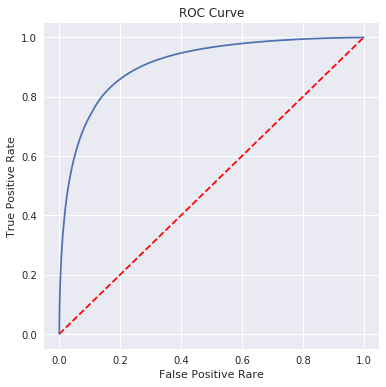

In [144]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(summary.roc.select('FPR').collect(),
         summary.roc.select('TPR').collect())
plt.xlabel('False Positive Rare')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.show()

## Conclusions <a class="anchor" id="bullet7"></a>
----------------------